# Building an NMF Model

In [1]:
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
import feather

Load in `reviews` and `beer-info` feather files, then merge them to produce a review database called `review_db` containing beer names, the user_id of the reviewer, and the score the user gave the beer.

In [2]:
reviews = feather.read_dataframe('../data/reviews.feather')
beer_info = feather.read_dataframe('../data/beer-info.feather')
review_db = reviews.merge(beer_info[['id','name']], left_on='beer_id', right_on='id')[['name','user_id','rating']]
review_db.head()

,name,user_id,rating
0,Surf Wax DIPA,Vasen_pakki,3.75
1,Surf Wax DIPA,Dave-Hill,3.50
2,Surf Wax DIPA,jsapas,3.75
3,Surf Wax DIPA,vanatyhi1,3.25
4,Surf Wax DIPA,stennibal,3.75


Convert the "tidy" `review_db` into a sparse matrix of `ratings` by pivoting on name and user_id, with intersections of reviewer/product interactions populated by the score that was given. Fill all missing values with zeroes. 

In [3]:
ratings = review_db.pivot_table(index='name', columns='user_id', values='rating', fill_value=0)
print(f'ratings is an M x N matrix, where M={ratings.shape[0]} and N={ratings.shape[1]}')
ratings.head()

ratings is an M x N matrix, where M=1403 and N=156862


user_id,--------,--JFG--,-1X,-7,-Alix-,-Beer,-C-,-Chubbs-,-Drake,-GMS-,...,zyphus,zysurge,zytle,zzDebra,zzandman,zzavilla,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
name,,,,,,,,,,,,,,,,,,,,,
(512) TWO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0.0
(New) English Bulldog Hazy IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0.0
(SIPAS) Hazy Session IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0.0
01 18 Off-Tempo DIPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0.0
04609 Double IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0.0


Words about SVD

In [4]:
%%time
s = np.linalg.svd(ratings, compute_uv=False)

Wall time: 34.1 s


Words about picking k

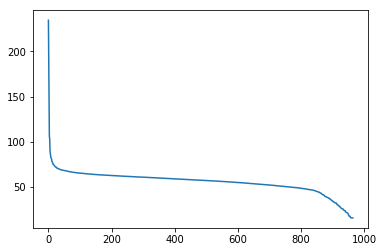

In [18]:
%matplotlib inline
pd.Series(s).iloc[:965].plot()

Select the number of components, k, and initialize the model. Fit and transform the model with the sparse matrix.

In [6]:
%%time
k = 6
model = NMF(n_components=k)
nmf_features = model.fit_transform(ratings)

Wall time: 44.3 s


The result of fitting and transforming the model will be the `beer_feat` table, containing one row for each beer and one column for each latent variable. 

In [7]:
beer_feat = pd.DataFrame(nmf_features, index=ratings.index)
print(f'beer_feat is an M x k matrix, where M={beer_feat.shape[0]} and k={beer_feat.shape[1]}')
beer_feat.head()

beer_feat is an M x k matrix, where M=1403 and k=6


,0,1,2,3,4,5
name,,,,,,
(512) TWO,0.024773,0.033585,0.000473,0.006082,0.003531,0.143933
(New) English Bulldog Hazy IPA,0.047608,0.029082,0.012588,0.031444,0.004227,0.073259
(SIPAS) Hazy Session IPA,0.000000,0.008265,0.007702,0.013535,0.000470,0.001660
01 18 Off-Tempo DIPA,0.006587,0.009576,0.020552,0.000533,0.033036,0.014431
04609 Double IPA,0.003699,0.000015,0.009249,0.021264,0.002628,0.041683


The components will be `user_feat` table, containing one column for each user and one row for each latent variable.

In [8]:
user_feat = pd.DataFrame(model.components_, columns=ratings.columns)
print(f'beer_feat is a k x N matrix, where k={user_feat.shape[0]} and N={user_feat.shape[1]}')
user_feat.head()

beer_feat is a k x N matrix, where k=6 and N=156862


user_id,--------,--JFG--,-1X,-7,-Alix-,-Beer,-C-,-Chubbs-,-Drake,-GMS-,...,zyphus,zysurge,zytle,zzDebra,zzandman,zzavilla,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
0,0.000810,0.000370,0.000000,0.001177,0.000027,0.245187,0.000400,0.000465,0.000223,0.000002,...,0.000000,1.325856e-07,0.000394,0.000422,0.000173,0.000090,0.000770,0.000059,0.000193,0.000823
1,0.000557,0.000101,0.270595,0.000199,0.000002,0.000000,0.001521,0.000226,0.000434,0.000079,...,0.269661,2.551067e-07,0.001191,0.000000,0.000358,0.000177,0.000537,0.000331,0.000142,0.000323
2,0.000156,0.000182,0.000000,0.000000,0.000022,0.000130,0.004235,0.000348,0.000573,0.000024,...,0.000000,7.668285e-07,0.003163,0.000000,0.000859,0.000708,0.321469,0.000018,0.000310,0.000446
3,0.000898,0.000252,0.000000,0.000086,0.000196,0.000068,0.000891,0.000095,0.002340,0.000166,...,0.000000,4.037531e-06,0.003921,0.001286,0.000124,0.000697,0.004251,0.000011,0.000282,0.000876
4,0.000220,0.000247,0.000813,0.000051,0.000128,0.000000,0.005514,0.006554,0.000784,0.000097,...,0.000000,1.077387e-06,0.000000,0.000155,0.000451,0.001139,0.000000,0.001483,0.000647,0.000632


Since `beer_feat` is M x k and `user_feat` is k x N, the dot product of the matrices will be M x N, producing a predictive matrix of `ratings` called `predictions`.

In [9]:
predictions = beer_feat.dot(user_feat).apply(lambda x: 0.25 * np.round(x/0.25))
predictions.head()

user_id,--------,--JFG--,-1X,-7,-Alix-,-Beer,-C-,-Chubbs-,-Drake,-GMS-,...,zyphus,zysurge,zytle,zzDebra,zzandman,zzavilla,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
name,,,,,,,,,,,,,,,,,,,,,
(512) TWO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(New) English Bulldog Hazy IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(SIPAS) Hazy Session IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01 18 Off-Tempo DIPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04609 Double IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
predictions.LetThereBeR0ck.describe()

count    1403.000000
mean        0.000178
std         0.006674
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.250000
Name: LetThereBeR0ck, dtype: float64

In [11]:
ratings.LetThereBeR0ck.describe()

count    1403.000000
mean        0.006237
std         0.165191
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.500000
Name: LetThereBeR0ck, dtype: float64